In this example, exact analytical trajectory of a charged particle moving in a uniform electric field is compared with results of numerical simulation. 

In uniform electric field charged particle moves with uniform acceleration, directed along the field.

\begin{align}
& \mathbf{v} = \mathbf{v}_0 + \frac{q}{m} \mathbf{E}_0 t
\\
& \mathbf{r} = \mathbf{r}_0 + \mathbf{v}_0 t + \frac{1}{2} \frac{q}{m} \mathbf{E}_0 t^2
\end{align}

Part of a config file, regarding single particle, is similar to 
['singe particle in free space'](https://github.com/epicf/ef/wiki/Ex1:-Single-Particle-In-Free-Space). 

In [1]:
from ef.config.components import *
timegrid = TimeGridConf(total=6e-09, save_step=6e-11, step=6e-12)
mesh = SpatialMeshConf((5, 5, 15), (.5, .5, 1.5))
source = ParticleSourceConf("emit_single_particle", Box((.1, .1, .1), (.01, .01, .01)), 1, 0,
                           (6e-19, 6e-19, 1.77e-18), 0., 4.8e-10, 9.8e-28)
file_config = OutputFileConf("single_particle_electric_field_")
field = ExternalElectricFieldUniformConf("uniform_z_field", (0, 0, 6))


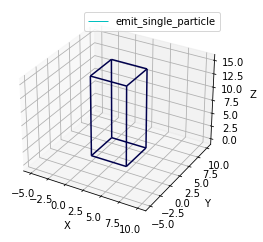

In [2]:
from ef.config.config import Config
from ef.config.visualizer import Visualizer3d
conf = Config(time_grid=timegrid, spatial_mesh=mesh, sources=[source], 
              external_fields=[field], output_file=file_config)
conf.visualize_all(Visualizer3d())

In [3]:
from ef.runner import Runner
Runner(conf.make(), output_writer=file_config.make()).start()

  Detected a Hermitian matrix
Writing initial fields to file
Writing to file single_particle_electric_field_fieldsWithoutParticles.h5
Writing step 0 to file
Writing to file single_particle_electric_field_0000000.h5
Time step from 9 to 10 of 1000
Writing step 10 to file
Writing to file single_particle_electric_field_0000010.h5
Time step from 19 to 20 of 1000
Writing step 20 to file
Writing to file single_particle_electric_field_0000020.h5
Time step from 29 to 30 of 1000
Writing step 30 to file
Writing to file single_particle_electric_field_0000030.h5
Time step from 39 to 40 of 1000
Writing step 40 to file
Writing to file single_particle_electric_field_0000040.h5
Time step from 49 to 50 of 1000
Writing step 50 to file
Writing to file single_particle_electric_field_0000050.h5
Time step from 59 to 60 of 1000
Writing step 60 to file
Writing to file single_particle_electric_field_0000060.h5
Time step from 69 to 70 of 1000
Writing step 70 to file
Writing to file single_particle_electric_field

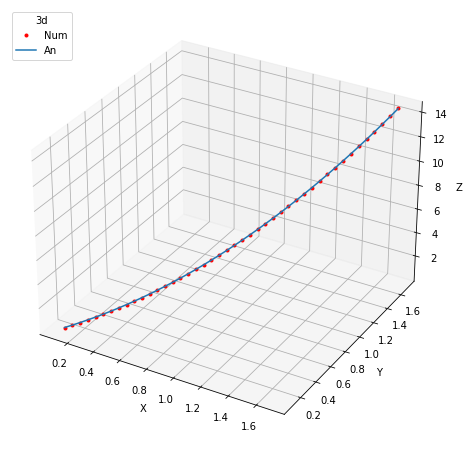

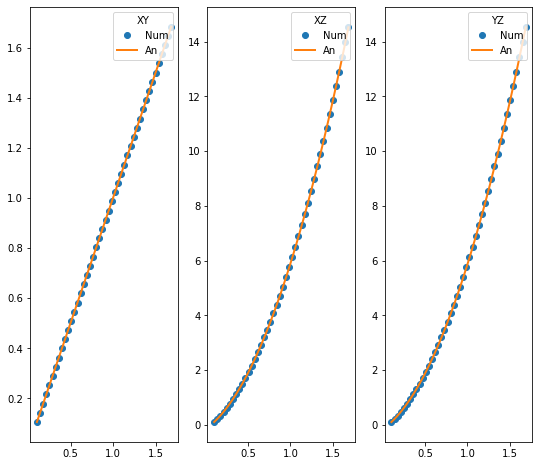

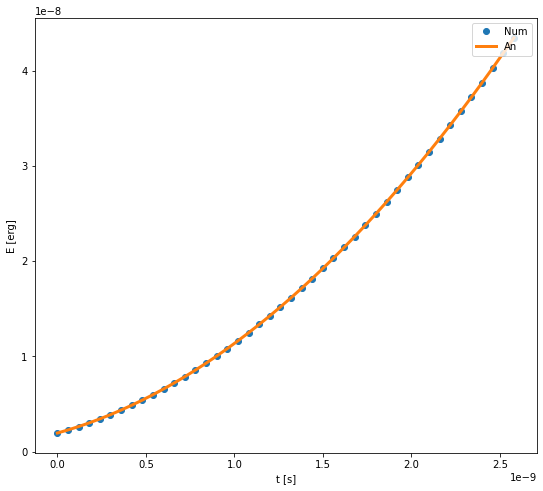

In [4]:
import os, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt 

def main():
    num = extract_num_trajectory_from_out_files()
    an = eval_an_trajectory_at_num_time_points( num )
    plot_trajectories( num , an )

def extract_num_trajectory_from_out_files():
    out_files = find_necessary_out_files()    

    num_trajectory = []
    for f in out_files:
        num_trajectory.append( extract_time_pos_mom( f ) )    

    num_trajectory = remove_empty_and_sort_by_time( num_trajectory )
    num_trajectory = np.array( num_trajectory, 
                               dtype=[('t','float'),
                                      ('x','float'), ('y','float'), ('z','float'),
                                      ('px','float'), ('py','float'), ('pz','float') ] )
    return( num_trajectory )

def remove_empty_and_sort_by_time( num_trajectory ):
    removed_empty = [ x for x in num_trajectory if x ]
    sorted_by_time = sorted( removed_empty, key = lambda x: x[0] )
    return ( sorted_by_time )

def find_necessary_out_files():
    os.chdir("./")
    h5files = []
    for file in glob.glob("single_particle_electric_field_[0-9][0-9][0-9][0-9][0-9][0-9][0-9].h5"):
        h5files.append( file )
    return h5files

def extract_time_pos_mom( h5file ):
    h5 = h5py.File( h5file, mode="r")
    t = h5["/TimeGrid"].attrs["current_time"][0]
    t_pos_mom = ()
    if ( len(h5["/ParticleSources/emit_single_particle/particle_id"]) > 0 ):
        x = h5["/ParticleSources/emit_single_particle/position_x"][0]
        y = h5["/ParticleSources/emit_single_particle/position_y"][0]
        z = h5["/ParticleSources/emit_single_particle/position_z"][0]
        px = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
        py = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
        pz = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
        t_pos_mom = (t, x, y, z, px, py, pz)
    h5.close()
    return( t_pos_mom )

def eval_an_trajectory_at_num_time_points( num_trajectory ):
    global mass, charge, E0
    mass, charge, x0, y0, z0, px0, py0, pz0 = get_mass_charge_and_initial_pos_and_mom()
    E0 = eval_field_amplitude()

    an_trajectory = np.empty_like( num_trajectory )
    for i, t in enumerate( num_trajectory['t'] ):
        x, y, z = coords( t, x0, y0, z0, px0, py0, pz0 )
        px, py, pz = momenta( t, px0, py0, pz0 )
        an_trajectory[i] = ( t, x, y ,z, px, py, pz )

    return( an_trajectory )

def get_mass_charge_and_initial_pos_and_mom():
    initial_out_file = "single_particle_electric_field_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    m = h5["/ParticleSources/emit_single_particle"].attrs["mass"][0]
    q = h5["/ParticleSources/emit_single_particle"].attrs["charge"][0]
    x0 = h5["/ParticleSources/emit_single_particle/position_x"][0]
    y0 = h5["/ParticleSources/emit_single_particle/position_y"][0]
    z0 = h5["/ParticleSources/emit_single_particle/position_z"][0]
    px0 = h5["/ParticleSources/emit_single_particle/momentum_x"][0]
    py0 = h5["/ParticleSources/emit_single_particle/momentum_y"][0]
    pz0 = h5["/ParticleSources/emit_single_particle/momentum_z"][0]
    h5.close()
    return( m, q, x0, y0, z0, px0, py0, pz0 )


def eval_field_amplitude():
    initial_out_file = "single_particle_electric_field_0000000.h5"
    h5 = h5py.File( initial_out_file, mode="r")
    E0 = h5["ExternalFields/uniform_z_field"].attrs["electric_uniform_field_z"]
    return E0
    

def momenta( t, px0, py0, pz0 ):
    global mass, charge, E0
    px = px0
    py = py0
    pz = pz0 + charge * E0 * t
    return ( px, py, pz )

def coords( t, x0, y0, z0, px0, py0, pz0 ):
    global mass, charge, E0
    x = x0 + px0 / mass * t
    y = y0 + py0 / mass * t
    z = z0 + pz0 / mass * t + 1 / 2 * charge / mass * E0 * t * t
    return ( x, y, z )

def plot_trajectories( num , an ):
    plot_3d( num, an )
    plot_2d( num, an )
    plot_kin_en( num , an )

def plot_3d( num, an ):
    fig = plt.figure()
    ax = fig.gca( projection='3d' )
    ax.plot( num['x'], num['y'], num['z'], '.r', label = "Num" )
    ax.plot( an['x'], an['y'], an['z'], label = "An" )
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Z')
    plt.legend( loc = 'upper left', title="3d" )
    plt.show()

def plot_2d( num, an ):
    plt.figure(1)
    #XY
    plt.subplot(131)
    plt.plot( num['x'], num['y'],
              linestyle='', marker='o',
              label = "Num" )
    plt.plot( an['x'], an['y'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    plt.legend( loc = 'upper right', title="XY" )
    #XZ
    plt.subplot(132)
    plt.plot( num['x'], num['z'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['x'], an['z'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    plt.legend( loc = 'upper right', title="XZ" )
    #YZ
    plt.subplot(133)
    plt.plot( num['y'], num['z'],
        linestyle='', marker='o',
        label = "Num" )
    plt.plot( an['y'], an['z'],
              linestyle='-', marker='', lw = 2,
              label = "An" )
    plt.legend( loc = 'upper right', title="YZ" )
    plt.show()
    
def plot_kin_en( num , an ):
    global mass
    E_num = ( num['px']**2 + num['py']**2 + num['pz']**2 ) / ( 2 * mass )
    E_an = ( an['px']**2 + an['py']**2 + an['pz']**2 ) / ( 2 * mass )
    t = num['t']
    plt.figure()
    axes = plt.gca()
    axes.set_xlabel( "t [s]" )
    axes.set_ylabel( "E [erg]" )
    # axes.set_ylim( [min( E_an.min(), E_num.min() ),
    #                 max( E_an.max(), E_num.max() ) ] )
    line, = plt.plot( t, E_num, 'o' )
    line.set_label( "Num" )
    line, = plt.plot( t, E_an, ls = 'solid', lw = 3 )
    line.set_label( "An" )
    plt.legend( loc = 'upper right' )
    plt.show()


main()
